In [ ]:
#
# Emre Alca
# University of Pennsylvania
# Created on Sat Nov 22 2025
# Last Modified: Sat Nov 22 2025 3:11:57 PM
#

In [1]:
import numpy as np
import trimesh
import tqdm
import matplotlib.pyplot as plt

from src import spindle_state as ss

from datetime import datetime

print(f"Emre Alca, {datetime.now().strftime('%Y-%m-%d')}")

Emre Alca, 2025-11-21


## Initializing a spherical discretization and the spindle state

- uniformly discretize a sphere with some number $N$ points. These points are our impingement sites. In this case, we make a mesh of triangles where the vertices are the impingement sites.
- choose some $M<N$ vertices as evenly spaced as possible within our discretization to place motors
- Initialize the spindle state, a list of $N$ numbers. 

In [2]:
boundary = trimesh.creation.icosphere(subdivisions=6, radius=1) # initializes discretized boundary boundary condition

boundary_sites = np.array(boundary.vertices) # gets coordinates of the vertices of boundary as a numpy array--these are our valid impingement sites

N = boundary_sites.shape[0] # number of total impingement sites
M = int(N / 100) # number of motors, set to 1% of all sites right now

print(N,M)

40962 409


In [3]:
# Generate N "evenly" spaced points on a unit sphere using a 
def fibonacci_sphere(samples):
    phi = np.pi * (3. - np.sqrt(5.))  # golden angle
    points = []
    for i in range(samples):
        y = 1 - (i / float(samples - 1)) * 2
        radius = np.sqrt(1 - y * y)
        theta = phi * i
        x = np.cos(theta) * radius
        z = np.sin(theta) * radius
        points.append([x, y, z])
    return np.array(points)

ideal_points = fibonacci_sphere(M)

# Find closest mesh vertex for each ideal point
fibonacci_indices = []
for p in ideal_points:
    distances = np.linalg.norm(boundary.vertices - p, axis=1)
    closest_idx = np.argmin(distances)
    fibonacci_indices.append(closest_idx)

selected_indices = np.unique(fibonacci_indices)  # remove duplicates if any
selected_vertices = boundary.vertices[selected_indices]

# print("Selected vertex indices:", selected_indices)

In [4]:
# initializing spindle state
# state is 1 where the boundary_sites is empty
# state is 3 where a motor is present

spindle_state = np.ones(N)

motor_indices = fibonacci_indices

spindle_state[motor_indices] = 3

spindle_state[0: 10]

array([1., 1., 1., 3., 1., 1., 1., 1., 1., 1.])

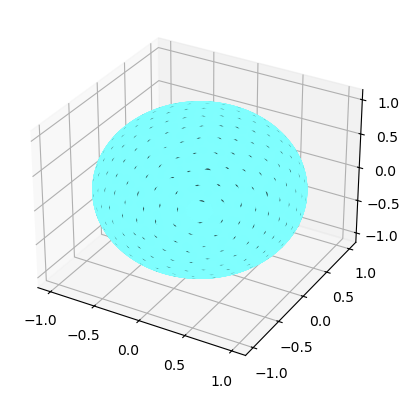

In [5]:
vertex_colors = np.array([1/(2*spindle_state), 1/spindle_state, 1/spindle_state]).T


colored_vertices = trimesh.points.PointCloud(boundary.vertices, colors=vertex_colors)

fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(boundary_sites[:,0], boundary_sites[:,1], boundary_sites[:,2], c=vertex_colors)
plt.show()


In [6]:
# highlighting vertices with motors

# Choose multiple vertices
target_vertices = motor_indices  # Example indices

# Find all faces that include any of these vertices
faces_touching_vertices = np.any(np.isin(boundary.faces, target_vertices), axis=1)

# Create face colors: default gray
face_colors = np.tile([200, 200, 200, 255], (len(boundary.faces), 1))

# Assign solid blue to faces touching any target vertex
face_colors[faces_touching_vertices] = [0, 0, 255, 255]

# Apply to mesh
boundary.visual.face_colors = face_colors

# Show interactive viewer
boundary.show()